In [1]:
# python env: modnenv_v2

import os
import string
import random
import numpy as np
from sklearn.model_selection import KFold
from pathlib import Path
import matplotlib.pyplot as plt
import json 
import pandas as pd
from copy import deepcopy
from modnet.models import EnsembleMODNetModel
from modnet.preprocessing import MODData
from modnet.hyper_opt import FitGenetic
from monty.serialization import dumpfn, loadfn
from pymatgen.ext.matproj import MPRester
from pymatgen.core.structure import Structure
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from scipy.stats import spearmanr
from IPython.display import Image
from tqdm import tqdm
import pickle
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2024-02-05 07:49:44.129014: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-05 07:49:44.150708: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-05 07:49:44.264159: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-05 07:49:44.264224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-05 07:49:44.282072: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# Loading previous cycle

Let's load the outputs of the previous selected compounds and recover all the relevant data into one dataframe

In [27]:
# prev_v = '3'
cur_v = 4

In [2]:

outprev_json_path = (Path('..') / f'v{cur_v-1}' / f'outputs_selected_v{cur_v-1}.json')
outprev_df_path = (Path('.') / f'df_outputs_v{cur_v}.pkl')


if outprev_df_path.exists():
    with open(outprev_df_path, 'rb') as f:
        df_outputs = pickle.load(f)
else:
    # read file
    with open(outprev_json_path, 'r') as myfile:
        data=myfile.read()

    # parse file
    obj = json.loads(data)


    out_mp_id = []
    out_eps_stat = [] #epsilon_ij_static
    out_ref_indices = [] #n1,n2, and n3 as sqrt(eps_ii)
    out_ref_index = [] #avg(n1, n2, n3)
    out_structure = []
    for o in obj:
        out_mp_id.append(o['metadata']["mp-id"])
        eps_ij = np.array(o['output']["calcs_reversed"][0]["output"]["epsilon_static"])
        out_eps_stat.append(eps_ij)
        try:
            out_ref_indices.append((eps_ij**0.5).diagonal())
            out_ref_index.append(np.trace(eps_ij**0.5)/3)
        except TypeError:
            out_ref_indices.append(np.nan)
            out_ref_index.append(np.nan)

        out_structure.append(o['output']["calcs_reversed"][0]["input"]["structure"])


    df_outputs = pd.DataFrame()
    df_outputs['eps_stat'] = out_eps_stat
    df_outputs['refractive_indices'] = out_ref_indices
    df_outputs['refractive_index'] = out_ref_index
    df_outputs['structure'] = out_structure
    df_outputs.index = out_mp_id


    with open('../v0/df_mp_2023_feat_filtered.pkl', 'rb') as f:
        df_mp_2023_feat_filtered = pickle.load(f)
    df_mp_2023_feat_filtered.shape


    # Load MP 2023 structures, bandgap, ehull
    path_structures_mp_2023 = (
        Path("./../../../") / "re2fractive_onedrive" / "data" / "mp2023_structures.json"
    )

    with open(path_structures_mp_2023, "r") as f:
        strucs_mp = json.load(f)

    # Filter the MP docs to remove Naccarato's dataset and the materials with refractive index
    strucs_mp_filt = [doc for doc in strucs_mp if doc["id"] in df_mp_2023_feat_filtered.index.values.flatten()]

    # Reorder the MP docs to match the order of the filtered MP MODData 
    strucs_mp_filt_odd = sorted(strucs_mp_filt, key=lambda x: list(df_mp_2023_feat_filtered.index.values.flatten()).index(x['id']))


    gap_out = []
    id_out = []
    for struc in strucs_mp_filt_odd:
        if struc['id'] in df_outputs.index.values:
            gap_out.append(struc['attributes']["_mp_band_gap"])
            id_out.append(struc['id'])

    zipped = zip(gap_out, id_out)
    gap_out_sorted = [g for g, i in sorted(zipped, key=lambda x: list(df_outputs.index.values.flatten()).index(x[1]))]

    df_outputs['bandgap'] = gap_out_sorted

    with open(outprev_df_path, 'wb') as f:
        pickle.dump(df_outputs, f)


print(df_outputs.shape)

/tmp/ipykernel_7092/1591337091.py:30: RuntimeWarning: invalid value encountered in sqrt
  out_ref_indices.append((eps_ij**0.5).diagonal())
/tmp/ipykernel_7092/1591337091.py:31: RuntimeWarning: invalid value encountered in sqrt
  out_ref_index.append(np.trace(eps_ij**0.5)/3)


(175, 5)


Let's visualize the outputs

In [3]:
# Load MP 2023 structures, bandgap, ehull
path_structures_naccarato = (
    Path("./../../../") / "re2fractive_onedrive" / "data" / "structures.json"
)
with open(path_structures_naccarato, "r") as f:
    strucs_naccarato = json.load(f)

In [4]:
import plotly.express as px
import plotly.graph_objects as go

gap_naccarato = [strucs_naccarato[mpid]["attributes"]["_naccarato_gga_bandgap"] for mpid in strucs_naccarato]
refractive_index_naccarato = [strucs_naccarato[mpid]["attributes"]["_naccarato_refractive_index"] for mpid in strucs_naccarato]

# Data
data_naccarato = {'x': gap_naccarato, 'y': refractive_index_naccarato}
data_outputs = {'x': df_outputs['bandgap'], 'y': df_outputs['refractive_index']}

# Scatter plot for Nacc.
scatter_naccarato = go.Scatter(
    x=data_naccarato['x'],
    y=data_naccarato['y'],
    mode='markers',
    marker=dict(symbol='x'),
    name='Nacc.'
)

# Scatter plot for MP pred.
scatter_mp_pred = go.Scatter(
    x=data_outputs['x'],
    y=data_outputs['y'],
    mode='markers',
    # error_y=data_outputs['error_y'],
    # marker='.',
    # line=dict(color='darkorange'),
    name=f'v{cur_v-1} outputs',
    text=[mpid for mpid in df_outputs.index.values]
)

# Layout
layout = go.Layout(
    title=dict(text='Scatter Plot'),
    xaxis=dict(title='$E_g$ (eV)', showgrid=True),
    yaxis=dict(title='$n$', showgrid=True),
    legend=dict(font=dict(size=12))
)

# Create figure
fig = go.Figure(data=[scatter_naccarato, scatter_mp_pred], layout=layout)

# Show figure
fig.show()

Let's remove the instances with NaN and potential outliers

In [8]:
outprev_df_filtout_path = (Path('.') / f'df_outputs_filtout_v{cur_v}.pkl')
lim_up   = 8
lim_down = 1.08

if outprev_df_filtout_path.exists():
    with open(outprev_df_filtout_path, 'rb') as f:
        df_outputs_filtout = pickle.load(f)
else:
    # NaN
    df_outputs = df_outputs.dropna()


    # Outliers
    outliers = df_outputs[(df_outputs['refractive_index']>lim_up) | (df_outputs['refractive_index']<=lim_down)]
    # display(outliers)

    gap_outliers = []
    id_outliers = []
    for struc in strucs_mp_filt_odd:
        if struc['id'] in outliers.index.values:
            gap_outliers.append(struc['attributes']["_mp_band_gap"])
            id_outliers.append(struc['id'])

    display(outliers)
    print(id_outliers)
    print(gap_outliers)

    for index, row in outliers.iterrows():
        s = Structure.from_dict(row['structure'])
        print(s.formula)
        print(row['refractive_index'])

    df_outputs_filtout = df_outputs.drop(outliers.index.values)

    with open(outprev_df_filtout_path, 'wb') as f:
        pickle.dump(df_outputs_filtout, f)


print(df_outputs_filtout.shape)

,eps_stat,refractive_indices,refractive_index,structure,bandgap
mp-1029424,"[[1.00000019, -1.1e-07, 0.0], [-1.1e-07, 0.999...","[1.0000000949999954, 0.9999999049999955, 1.0]",1.000000,"{'@module': 'pymatgen.core.structure', '@class...",3.1335
mp-676072,"[[1, 0, 0], [0, 1, 0], [0, 0, 1]]","[1.0, 1.0, 1.0]",1.000000,"{'@module': 'pymatgen.core.structure', '@class...",1.2038
mp-1207204,"[[119294.84565571, 12157.61732569, 3393.631722...","[345.39085925326685, 519.909325587799, 626.273...",497.191116,"{'@module': 'pymatgen.core.structure', '@class...",7.4832
mp-4757,"[[48171.7250462, -17.88805548, 0.0], [17.88805...","[219.48058011177207, 219.48058011177207, 166.6...",201.854685,"{'@module': 'pymatgen.core.structure', '@class...",3.7244
mp-677372,"[[1, 0, 0], [0, 1, 0], [0, 0, 1]]","[1.0, 1.0, 1.0]",1.000000,"{'@module': 'pymatgen.core.structure', '@class...",1.9872
mp-1219645,"[[85.92194019, 0.0, 0.0], [0.0, 2147.85236061,...","[9.26940883713735, 46.34492810017078, 3.153996...",19.589444,"{'@module': 'pymatgen.core.structure', '@class...",1.0521
mp-1029492,"[[1, 0, 0], [0, 1, 0], [0, 0, 1]]","[1.0, 1.0, 1.0]",1.000000,"{'@module': 'pymatgen.core.structure', '@class...",3.2905
mp-1225650,"[[320898.86217587, -88569.99147023, -100416.41...","[566.4793572371989, 531.3972722660515, 411.231...",503.035983,"{'@module': 'pymatgen.core.structure', '@class...",4.1461
mp-561799,"[[0.99999998, -3e-08, 2e-08], [-3e-08, 0.99999...","[0.99999999, 0.9999999849999999, 1.00000002499...",1.000000,"{'@module': 'pymatgen.core.structure', '@class...",2.7646
mp-1210775,"[[2564907.81182475, 0.0, 0.0], [0.0, 165216.69...","[1601.53295683378, 406.4685687234377, 1361.419...",1123.140214,"{'@module': 'pymatgen.core.structure', '@class...",5.0615


['mp-1029424', 'mp-1029492', 'mp-1173113', 'mp-1207204', 'mp-1210775', 'mp-1214815', 'mp-1219645', 'mp-1222825', 'mp-1224122', 'mp-1225650', 'mp-4757', 'mp-557483', 'mp-561799', 'mp-676072', 'mp-677372']
[3.1334999999999997, 3.2904999999999998, 1.6703999999999999, 7.4832, 5.0615000000000006, 0.7749999999999999, 1.0521, 4.1179, 4.132, 4.1461, 3.7244, 6.0550999999999995, 2.7646, 1.2038000000000002, 1.9871999999999996]
Li2 Ti4 N6
0.999999999999997
Ce4 Pb2 Se8
1.0
Lu1 F3
497.19111607679105
K2 Re2 O8
201.85468459524031
Ti10 Bi1 Pb9 O30
1.0
Rb2 Bi8 Se14
19.5894443706682
Li24 Co8 N16
1.0
Er4 Zr3 O12
503.0359826747136
Yb8 Ga16 S32
0.9999999999999997
Lu4 O4 F4
1123.140213593667
Lu4 Zr3 O12
963.3588702046176
Tb10 Yb1 Se16
1.0
Yb2 Cl2 F2
1.0
Ho4 Zr3 O12
229.6512377237783
Co2 N8 F24
1.07640260590543
(157, 5)


In [9]:
import plotly.express as px
import plotly.graph_objects as go

gap_naccarato = [strucs_naccarato[mpid]["attributes"]["_naccarato_gga_bandgap"] for mpid in strucs_naccarato]
refractive_index_naccarato = [strucs_naccarato[mpid]["attributes"]["_naccarato_refractive_index"] for mpid in strucs_naccarato]

# Data
data_naccarato = {'x': gap_naccarato, 'y': refractive_index_naccarato}
data_outputs = {'x': df_outputs_filtout['bandgap'], 'y': df_outputs_filtout['refractive_index']}

# Scatter plot for Nacc.
scatter_naccarato = go.Scatter(
    x=data_naccarato['x'],
    y=data_naccarato['y'],
    mode='markers',
    marker=dict(symbol='x'),
    name='Nacc.'
)

# Scatter plot for MP pred.
scatter_mp_pred = go.Scatter(
    x=data_outputs['x'],
    y=data_outputs['y'],
    mode='markers',
    # error_y=data_outputs['error_y'],
    # marker='.',
    # line=dict(color='darkorange'),
    name=f'v{cur_v-1} outputs',
    text=[mpid for mpid in df_outputs_filtout.index.values]
)

# Layout
layout = go.Layout(
    title=dict(text='Scatter Plot'),
    xaxis=dict(title='$E_g$ (eV)', showgrid=True),
    yaxis=dict(title='$n$', showgrid=True),
    legend=dict(font=dict(size=12))
)

# Create figure
fig = go.Figure(data=[scatter_naccarato, scatter_mp_pred], layout=layout)

# Show figure
fig.show()

In [10]:
# Let's check if any compounds (post outliers filter) contain some Yb (in which case they should be discarded since there was some issue with the Yb psp v54)
from pymatgen.core.structure import Structure
from pymatgen.core.periodic_table import Element
yb = Element('Yb')
for s in df_outputs_filtout['structure']:
    elem = Structure.from_dict(s).composition.elements
    if yb in elem:
        print(elem)

Let's see how well the previous model predicted the newly acquired outputs

In [11]:
with open(f'../v{cur_v-1}/results_mp_v{cur_v-1}.pkl', 'rb') as f:
    results_pred_prev, results_unc_prev = pickle.load(f)

results_pred_prev = results_pred_prev.filter(items=df_outputs_filtout.index.values, axis=0)
results_unc_prev = results_unc_prev.filter(items=df_outputs_filtout.index.values, axis=0)

In [12]:
# Data
data_prev_outputs = {'x': df_outputs_filtout['refractive_index'], 
                     'y': results_pred_prev['refractive_index'], 
                     'error_y': results_unc_prev['refractive_index'],
                     'color': df_outputs_filtout['bandgap']}


mae = mean_absolute_error(data_prev_outputs['x'], data_prev_outputs['y'])
rmse = mean_squared_error(data_prev_outputs['x'], data_prev_outputs['y'])
spearmanrho = spearmanr(data_prev_outputs['x'], data_prev_outputs['y'])
print(f"MAE = {mae}")
print(f"RMSE = {rmse}")
print(f"Rho_sp = {spearmanrho.statistic}")

# Scatter plot for previous outputs.
scatter_outputs_prev = go.Scatter(
    x=data_prev_outputs['x'],
    y=data_prev_outputs['y'],
    mode='markers',
    error_y=dict(
        array=data_prev_outputs['error_y'],
        color='gray',
        thickness=1,
        visible=True,
        ),
    marker=dict(
        color=data_prev_outputs['color'],
        colorbar=dict(
            title="<i>E<sub>g</sub></i> (eV)"
        ),
        colorscale="Plasma"
    ),
    line=dict(color='darkorange'),
    name=f'v{cur_v-1} outputs',
    showlegend=False,
    text=[mpid for mpid in df_outputs_filtout.index.values]
)

ideal = go.Scatter(
    x=[-100,100],
    y=[-100,100],
    mode="lines",
    line=dict(color='gray', dash='dot'),
    showlegend=False
)

# Layout
layout = go.Layout(
    title=dict(text='Scatter Plot'),
    xaxis=dict(title='Computed n', showgrid=True,  range=[0,8]),
    yaxis=dict(title='Predicted n', showgrid=True, range=[0,8]),
    legend=dict(font=dict(size=12)),
)

# Create figure
fig = go.Figure(data=[scatter_outputs_prev,ideal], layout=layout)

fig.update_layout(
    autosize=False,
    width=600,
    height=600,
    # margin=dict(
    #     l=50,
    #     r=50,
    #     b=100,
    #     t=100,
    #     pad=4
    # ),
    # paper_bgcolor="LightSteelBlue",
)

# Show figure
fig.show()

MAE = 0.186399852778884
RMSE = 0.07940423358853735
Rho_sp = 0.9518509789815118


# Updating to this cycle

In [31]:
modd_nac_prev_path = (Path('..') / f'v{cur_v-1}' / f'mod.data_refeatselec_v{cur_v-1}')
modd_nac_new_path = (Path('.') / f'mod.data_refeatselec_v{cur_v}')

if modd_nac_new_path.exists():
    md_naccarato_new = MODData.load(modd_nac_new_path)
else:
    # Load the previous training MODData
    md_naccarato_prev = MODData.load(modd_nac_prev_path)

    with open('../v0/df_mp_2023_feat_filtered.pkl', 'rb') as f:
        df_mp_2023_feat_filtered = pickle.load(f)
    print(df_mp_2023_feat_filtered.shape)

    df_outputs_featurized = df_mp_2023_feat_filtered.filter(items=df_outputs_filtout.index.values, axis=0)\
                                                    .filter(items=md_naccarato_prev.df_featurized.columns.values.flatten(), axis=1)
    print(df_outputs_featurized.shape)

    # Let's remove the two Yb compounds with n=1 from the v1 iteration 
    md_naccarato_prev.df_featurized = md_naccarato_prev.df_featurized.drop(['mp-1215632','mp-1212307'], axis=0)
    md_naccarato_prev.df_targets = md_naccarato_prev.df_targets.drop(['mp-1215632','mp-1212307'], axis=0)

    md_naccarato_new = MODData(
                            df_featurized   = pd.concat([md_naccarato_prev.df_featurized, df_outputs_featurized]),
                        )
    md_naccarato_new.df_targets = pd.concat([md_naccarato_prev.df_targets, df_outputs_filtout.filter(items=['refractive_index'], axis=1)])
    md_naccarato_new.optimal_features = md_naccarato_prev.optimal_features
    md_naccarato_new.optimal_features_by_target = md_naccarato_prev.optimal_features_by_target
    md_naccarato_new.num_classes = md_naccarato_prev.num_classes

    md_naccarato_new.save(modd_nac_new_path)


print(md_naccarato_new.df_featurized.shape)

2024-02-05 09:09:35,563 - modnet - INFO - Loaded <modnet.preprocessing.MODData object at 0x7fa4cc5fae20> object, created with modnet version 0.4.1


(24186, 4565)
(157, 3019)
2024-02-05 09:09:36,048 - modnet - INFO - Data successfully saved as mod.data_refeatselec_v4!
(4522, 3019)


# Benchmark

In [32]:
kf = KFold(5, shuffle=True, random_state=42)

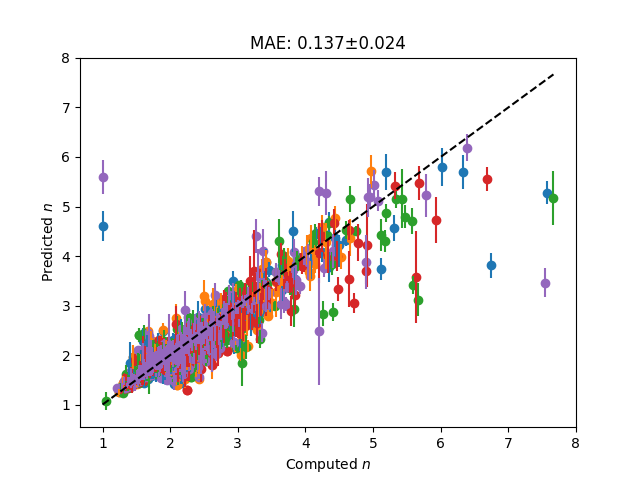

In [12]:
targets = ["refractive_index"]
experiment_name = "GA2_kfold_ensemble-" + "-".join(targets)
scores = []


fig_bk_ntd0_path = (Path(".") / "models" / "fitgenetic_2" / f"{experiment_name}.png")

if fig_bk_ntd0_path.exists():
    fig = Image(filename=fig_bk_ntd0_path)
    display(fig)
else:
    for ind, (train, test) in enumerate(
        kf.split(md_naccarato_new.df_featurized, y=md_naccarato_new.df_targets)
    ):
        train_moddata, test_moddata = md_naccarato_new.split((train, test))
        model_path = (
            Path(".") / "models" / "fitgenetic_2" / f"{experiment_name}_{ind}.pkl"
        )
        print(model_path)
        if model_path.exists():
            model = EnsembleMODNetModel.load(model_path)

        else:
            ga = FitGenetic(train_moddata)
            model = ga.run(
                size_pop=20, # dflt
                num_generations=10, # dflt
                nested=0, # dflt = 5
                n_jobs=2,
                early_stopping=4, # dflt
                refit=0, # dflt = 5
                fast=False,
            )
            model.save(model_path)

        scores.append(model.evaluate(test_moddata))

        predictions, uncertainties = model.predict(test_moddata, return_unc=True)

        plt.scatter(
            test_moddata.df_targets.values.ravel(),
            predictions.values.ravel(),
        )
        plt.errorbar(
            test_moddata.df_targets.values.ravel(),
            predictions.values.ravel(),
            yerr=uncertainties.values.ravel(),
            ls="none",
        )

    print("="*10 + f" {experiment_name} " + "="*10)
    print("Training complete.")
    print("Training complete.")
    print(f"Accuracy: {np.mean(scores):.3f}±{np.std(scores):.3f}")

    plt.plot(
        np.linspace(
            np.min(md_naccarato_new.df_targets.values),
            np.max(md_naccarato_new.df_targets.values),
            3,
        ),
        np.linspace(
            np.min(md_naccarato_new.df_targets.values),
            np.max(md_naccarato_new.df_targets.values),
            3,
        ),
        color="black",
        ls="--",
    )

    plt.ylabel("Predicted $n$")
    plt.xlabel("Computed $n$")
    # plt.xlim((-1,30))
    # plt.ylim((-1,30))
    plt.title(f"MAE: {np.mean(scores):.3f}±{np.std(scores):.3f}")

    plt.savefig(fig_bk_ntd0_path)
    plt.savefig(Path(str(fig_bk_ntd0_path).replace("png", "pdf")))


models/fitgenetic_3/GA3_kfold_ensemble-refractive_index_0.pkl
2024-02-05 15:06:01,311 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fa36c6f33a0> object, created with modnet version 0.4.1
29/29 [==============================] - 0s 4ms/step
models/fitgenetic_3/GA3_kfold_ensemble-refractive_index_1.pkl
2024-02-05 15:06:53,965 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fa3ac37fdf0> object, created with modnet version 0.4.1
29/29 [==============================] - 0s 4ms/step
models/fitgenetic_3/GA3_kfold_ensemble-refractive_index_2.pkl
2024-02-05 15:07:34,436 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fa508ccf850> object, created with modnet version 0.4.1
29/29 [==============================] - 0s 2ms/step
models/fitgenetic_3/GA3_kfold_ensemble-refractive_index_3.pkl
2024-02-05 15:08:05,976 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fa50

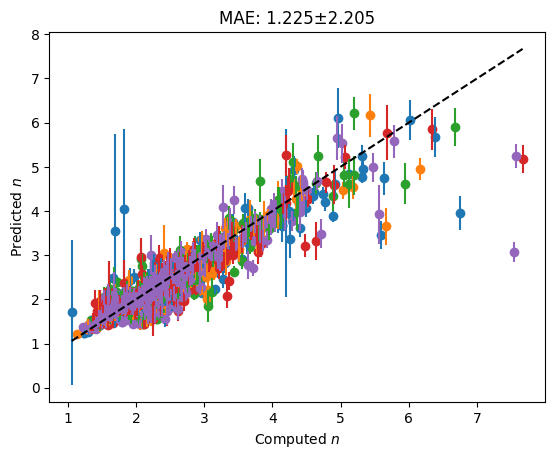

In [37]:
targets = ["refractive_index"]
experiment_name = "GA3_kfold_ensemble-" + "-".join(targets)
scores = []
pred_mae = []


fig_bk_ntd5_path = (Path(".") / "models" / "fitgenetic_3" / f"{experiment_name}.png")

if fig_bk_ntd5_path.exists():
    fig = Image(filename=fig_bk_ntd5_path)
    display(fig)
else:
    for ind, (train, test) in enumerate(
        kf.split(md_naccarato_new.df_featurized, y=md_naccarato_new.df_targets)
    ):
        train_moddata, test_moddata = md_naccarato_new.split((train, test))
        model_path = (
            Path(".") / "models" / "fitgenetic_3" / f"{experiment_name}_{ind}.pkl"
        )
        print(model_path)
        if model_path.exists():
            model = EnsembleMODNetModel.load(model_path)
    
        else:
            ga = FitGenetic(train_moddata)
            model = ga.run(
                size_pop=20, # dflt
                num_generations=10, # dflt
                nested=5, # dflt = 5
                n_jobs=2,
                early_stopping=4, # dflt
                refit=0, # dflt = 5
                fast=False,
            )
            model.save(model_path)
    
        scores.append(model.evaluate(test_moddata))
    
        predictions, uncertainties = model.predict(test_moddata, return_unc=True)
        pred_mae.append(mean_absolute_error(test_moddata.df_targets.values.ravel(), predictions.values.ravel()))
    
        plt.scatter(
            test_moddata.df_targets.values.ravel(),
            predictions.values.ravel(),
        )
        plt.errorbar(
            test_moddata.df_targets.values.ravel(),
            predictions.values.ravel(),
            yerr=uncertainties.values.ravel(),
            ls="none",
        )
    
    print("="*10 + f" {experiment_name} " + "="*10)
    print("Training complete.")
    print("Training complete.")
    print(f"Accuracy: {np.mean(scores):.3f}±{np.std(scores):.3f}")
    print(scores)
    
    plt.plot(
        np.linspace(
            np.min(md_naccarato_new.df_targets.values),
            np.max(md_naccarato_new.df_targets.values),
            3,
        ),
        np.linspace(
            np.min(md_naccarato_new.df_targets.values),
            np.max(md_naccarato_new.df_targets.values),
            3,
        ),
        color="black",
        ls="--",
    )
    
    plt.ylabel("Predicted $n$")
    plt.xlabel("Computed $n$")
    plt.title(f"MAE: {np.mean(scores):.3f}±{np.std(scores):.3f}")

    plt.savefig(fig_bk_ntd5_path)
    plt.savefig(Path(str(fig_bk_ntd5_path).replace("png", "pdf")))


In [38]:
pred_mae

[0.10928648508601863,
 0.09249321625807705,
 0.10190983598174708,
 0.09456118160035278,
 0.1085585071998668]

# Production

## Training on the whole dataset

In [ ]:
# targets = ["refractive_index"]
# experiment_name = "GA_Rf0_Nstd0-" + "-".join(targets)
# scores = []

# model_path = (
#     Path(".") / "models" / "production" / f"{experiment_name}_prod_v2.pkl"
# )

# if model_path.exists():
#     model = EnsembleMODNetModel.load(model_path)

# else:
#     ga = FitGenetic(md_naccarato_new)
#     model = ga.run(
#         size_pop=20, # dflt
#         num_generations=10, # dflt
#         nested=0, # dflt = 5
#         n_jobs=4,
#         early_stopping=4, # dflt
#         refit=0, # dflt = 5
#         fast=False,
#     )
#     model.save(model_path)

2024-01-09 09:04:51,778 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f5bc046d220> object, created with modnet version 0.4.1


In [14]:
targets = ["refractive_index"]
experiment_name = "GA_Rf0_Nstd5-" + "-".join(targets)
scores = []

model_path = (
    Path(".") / "models" / "production" / f"{experiment_name}_prod_v{cur_v}.pkl"
)

if model_path.exists():
    model = EnsembleMODNetModel.load(model_path)

else:
    ga = FitGenetic(md_naccarato_new)
    model = ga.run(
        size_pop=20, # dflt
        num_generations=10, # dflt
        nested=5, # dflt = 5
        n_jobs=2,
        early_stopping=4, # dflt
        refit=0, # dflt = 5
        fast=False,
    )
    model.save(model_path)

2024-01-22 19:13:05,450 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f13a7437100> object, created with modnet version 0.4.1


## Preparing the MP for prediction

In [15]:
moddmp_path = (
    Path(".") / f"mod.data_mp2023_filtered_v{cur_v}"
)

df_outputs_prev_paths = [(Path('..') / f'v{i+1}' / f'df_outputs_v{i+1}.pkl') for i in range(cur_v-1)]
df_outputs_prev_paths.append((Path('.') / f'df_outputs_v{cur_v}.pkl'))

# v1 - stopped by accident -> retry the non-finished
# v2 - stopped by Lucia failure -> retry the non-finished
# v3 - all done except weird errors
# v4


if moddmp_path.exists():
    # Load the prepared (filtered) MP MODData
    md_mp_filt = MODData.load(moddmp_path)
else:
    with open('../v0/df_mp_2023_feat_filtered.pkl', 'rb') as f:
        df_mp_2023_feat_filtered = pickle.load(f)
    print(df_mp_2023_feat_filtered.shape)

    with open(df_outputs_prev_paths[0], 'rb') as f:
        df_outputs_prevs = pickle.load(f)
    print(df_outputs_prevs.shape)
    for path in df_outputs_prev_paths[1:]:
        with open(path, 'rb') as f:
            df_tmp = pickle.load(f)
        print(df_tmp.shape)
        df_outputs_prevs = pd.concat([df_outputs_prevs, df_tmp])


    df_mp_2023_feat_filtered = df_mp_2023_feat_filtered.drop(index=df_outputs_prevs.index.values)
    print(df_mp_2023_feat_filtered.shape)


    # Load MP 2023 structures, bandgap, ehull
    path_structures_mp_2023 = (
        Path("./../../../") / "re2fractive_onedrive" / "data" / "mp2023_structures.json"
    )
    with open(path_structures_mp_2023, "r") as f:
        strucs_mp = json.load(f)

    # Filter the MP docs to remove Naccarato's dataset and the materials with refractive index
    strucs_mp_filt = [doc for doc in strucs_mp if doc["id"] in df_mp_2023_feat_filtered.index.values.flatten()]

    # Reorder the MP docs to match the order of the filtered MP MODData 
    strucs_mp_filt_odd = sorted(strucs_mp_filt, key=lambda x: list(df_mp_2023_feat_filtered.index.values.flatten()).index(x['id']))

    print(len(strucs_mp_filt_odd))


    # Recover a dataframe of Pymatgen Structures from the optimade docs
    from optimade.adapters import Structure as optim_Structure
    df_mp_structures = pd.DataFrame.from_dict(
        {doc["id"]: {"structure": optim_Structure(doc).as_pymatgen} for doc in strucs_mp_filt_odd}, orient="index"
    )

    # Instantiate a MODData for the filtered MP
    md_mp_filt = MODData(
        materials=df_mp_structures['structure'],
        df_featurized = df_mp_2023_feat_filtered,
        structure_ids=df_mp_2023_feat_filtered.index.values.flatten(),
    )
    md_mp_filt.save(moddmp_path)

print(md_mp_filt.df_featurized.shape)

22/22 [==============================] - 0s 2ms/step
2024-01-22 19:13:25,291 - modnet - INFO - Loaded <modnet.preprocessing.MODData object at 0x7f141d97b0d0> object, created with modnet version 0.4.1
(23776, 4565)


In [16]:
results_path = (
    Path(".") / f"results_mp_v{cur_v}.pkl"
)

if results_path.exists():
    with open(results_path, 'rb') as f:
        results = pickle.load(f)
else:
    # Predict the filtered MP
    results = model.predict(md_mp_filt, return_unc=True)

    with open(results_path, 'wb') as f:
        pickle.dump(results, f)


# Recover the predictions and the associated uncertainties
predictions, uncertainties = results

## Vis. n-Eg

#### Recover Naccarato dataset bandgap

In [17]:
# Load MP 2023 structures, bandgap, ehull
path_structures_naccarato = (
    Path("./../../../") / "re2fractive_onedrive" / "data" / "structures.json"
)
with open(path_structures_naccarato, "r") as f:
    strucs_naccarato = json.load(f)

gap_naccarato = [strucs_naccarato[mpid]["attributes"]["_naccarato_gga_bandgap"] for mpid in strucs_naccarato]
refractive_index_naccarato = [strucs_naccarato[mpid]["attributes"]["_naccarato_refractive_index"] for mpid in strucs_naccarato]

data_naccarato = {'x': gap_naccarato, 'y': refractive_index_naccarato}

#### Recover computer candidates

In [36]:
# outprev_df_filtout_paths = [
#     (Path('..') / 'v1' / 'df_outputs_filtout_v1.pkl'),
#     (Path('..') / 'v2' / 'df_outputs_filtout_v2.pkl'),
#     (Path('..') / 'v3' / 'df_outputs_filtout_v3.pkl'),
#     (Path('.') / f'df_outputs_filtout_{cur_v}.pkl'),
#     ]
outprev_df_filtout_paths = [(Path('..') / f'v{i+1}' / f'df_outputs_filtout_v{i+1}.pkl') for i in range(cur_v-1)]
outprev_df_filtout_paths.append((Path('.') / f'df_outputs_filtout_v{cur_v}.pkl'))

with open(outprev_df_filtout_paths[0], 'rb') as f:
    df_outputs_filtouts = pickle.load(f)
print(df_outputs_filtouts.shape)
for path in outprev_df_filtout_paths[1:]:
    with open(path, 'rb') as f:
        df_tmp = pickle.load(f)
    print(df_tmp.shape)
    df_outputs_filtouts = pd.concat([df_outputs_filtouts, df_tmp])

print(df_outputs_filtouts.shape)

data_outputs_filtouts = {'x': df_outputs_filtouts['bandgap'], 'y': df_outputs_filtouts['refractive_index']}

(69, 5)
(138, 5)
(159, 5)
(366, 5)


#### Recover predicted MP

In [19]:
md_mp_filt = MODData.load(moddmp_path)
    
path_structures_mp_2023 = (
    Path("./../../../") / "re2fractive_onedrive" / "data" / "mp2023_structures.json"
)
with open(path_structures_mp_2023, "r") as f:
    strucs_mp = json.load(f)

# Filter the MP docs to remove Naccarato's dataset and the materials with refractive index
strucs_mp_filt = [doc for doc in strucs_mp if doc["id"] in md_mp_filt.df_featurized.index.values.flatten()]

# Reorder the MP docs to match the order of the filtered MP MODData 
strucs_mp_filt_odd = sorted(strucs_mp_filt, key=lambda x: list(md_mp_filt.df_featurized.index.values.flatten()).index(x['id']))


gap_mp = [struc['attributes']["_mp_band_gap"] for struc in strucs_mp_filt_odd]
refractive_index_mp_pred = predictions.refractive_index.values.flatten()
refractive_index_mp_unc = uncertainties.refractive_index.values.flatten()

data_mp_pred = {'x': gap_mp, 'y': refractive_index_mp_pred, 'error_y': {'array': refractive_index_mp_unc, 'visible': True}}

22/22 [==============================] - 0s 1ms/step
2024-01-22 19:13:51,051 - modnet - INFO - Loaded <modnet.preprocessing.MODData object at 0x7f13a73b8a30> object, created with modnet version 0.4.1
22/22 [==============================] - 0s 2ms/step


22/22 [==============================] - 0s 1ms/step


### Vis.

In [20]:
# Scatter plot for Nacc.
scatter_naccarato = go.Scatter(
    x=data_naccarato['x'],
    y=data_naccarato['y'],
    mode='markers',
    marker=dict(symbol='x'),
    name='Nacc.',
    opacity=0.5
)

# Scatter plot for the current v outputs without the outliers.
scatter_outputs_filtout = go.Scatter(
    x=data_outputs_filtouts['x'],
    y=data_outputs_filtouts['y'],
    mode='markers',
    marker=dict(symbol='x'),
    name='Out. prev.',
    opacity=0.5
)

# Scatter plot for MP pred.
scatter_mp_pred = go.Scatter(
    x=data_mp_pred['x'],
    y=data_mp_pred['y'],
    mode='markers',
    error_y=data_mp_pred['error_y'],
    # marker='.',
    # line=dict(color='darkorange'),
    name='MP pred.',
    text=[struc["id"] for struc in strucs_mp_filt_odd],
    opacity=0.5
)

# Layout
layout = go.Layout(
    title=dict(text='Scatter Plot'),
    xaxis=dict(title='$E_g$ (eV)', showgrid=True),
    yaxis=dict(title='$n$', showgrid=True),
    legend=dict(font=dict(size=12))
)

# Create figure
fig = go.Figure(data=[scatter_naccarato, scatter_outputs_filtout, scatter_mp_pred], layout=layout)

# Show figure
fig.show()

22/22 [==============================] - 0s 1ms/step


## Selection candidates

First let's put all the necessary information into one dataframe

In [21]:
ehull_mp_filt_odd = [struc['attributes']["_mp_energy_above_hull"] for struc in strucs_mp_filt_odd]
nsites_mp_filt_odd = [struc['attributes']["nsites"] for struc in strucs_mp_filt_odd]

In [22]:
predictions['nsites'] = nsites_mp_filt_odd
predictions['ehull'] = np.array(ehull_mp_filt_odd)
predictions['refractive_index_unc'] = uncertainties['refractive_index'].values
predictions['bandgap'] = gap_mp
predictions['structure'] = [struc.as_dict() for struc, mpid in zip(md_mp_filt.structures, md_mp_filt.structure_ids) if mpid in predictions.index]

22/22 [==============================] - 0s 1ms/step


Second let's remove the obvious outliers

In [23]:
outliers = ['mp-568145', 'mp-23155', 'mp-111', 'mp-754382', 'mp-23158', 'mp-23156', 'mp-614456']
predictions = predictions.drop(outliers, axis=0)

22/22 [==============================] - 0s 934us/step


Third let's put all the necessary information into one dataframe

In [24]:
predictions['fom_energy'] = np.sqrt(predictions['bandgap'])*(predictions['refractive_index']+predictions['refractive_index_unc'])**2
predictions['fom_leak'] = predictions['bandgap']*(predictions['refractive_index']+predictions['refractive_index_unc'])**2

In [25]:
fom_energy_minmax = (predictions['fom_energy']-min(predictions['fom_energy']))/(max(predictions['fom_energy'])-min(predictions['fom_energy']))
fom_leak_minmax = (predictions['fom_leak']-min(predictions['fom_leak']))/(max(predictions['fom_leak'])-min(predictions['fom_leak']))

In [26]:
predictions['avg_fom'] = (fom_energy_minmax+fom_leak_minmax)/2

In [28]:
predictions = predictions[predictions['nsites']<100]
predictions = predictions[predictions['ehull']<0.025] # already satisfied to begin with
predictions

,refractive_index,nsites,ehull,refractive_index_unc,bandgap,structure,fom_energy,fom_leak,avg_fom
mp-10009,3.235733,8,0.000000,0.134071,0.7853,"{'@module': 'pymatgen.core.structure', '@class...",10.062993,8.917538,0.147256
mp-1001012,2.188065,14,0.009354,0.215280,0.5768,"{'@module': 'pymatgen.core.structure', '@class...",4.386772,3.331637,0.050999
mp-1001019,2.458214,14,0.003289,0.214893,1.0918,"{'@module': 'pymatgen.core.structure', '@class...",7.466279,7.801458,0.113649
mp-1001024,2.273826,14,0.003040,0.114123,1.7768,"{'@module': 'pymatgen.core.structure', '@class...",7.600973,10.131843,0.131855
mp-1001080,1.543234,12,0.004743,0.098789,5.6848,"{'@module': 'pymatgen.core.structure', '@class...",6.428594,15.327579,0.157975
...,...,...,...,...,...,...,...,...,...
mp-999471,2.674737,4,0.000000,0.212763,1.8121,"{'@module': 'pymatgen.core.structure', '@class...",11.223672,15.108663,0.203517
mp-999474,2.597392,4,0.000000,0.204820,1.8867,"{'@module': 'pymatgen.core.structure', '@class...",10.785824,14.815106,0.197086
mp-999488,2.593472,4,0.000000,0.202507,1.8635,"{'@module': 'pymatgen.core.structure', '@class...",10.671673,14.567909,0.194174
mp-999489,2.662052,4,0.000000,0.219136,1.3585,"{'@module': 'pymatgen.core.structure', '@class...",9.675489,11.277238,0.160543


In [29]:
pred_sorted = predictions.sort_values(by=['avg_fom'], ascending=False)

In [30]:
df_selected = pred_sorted.iloc[:200]
df_selected

,refractive_index,nsites,ehull,refractive_index_unc,bandgap,structure,fom_energy,fom_leak,avg_fom
mp-1214500,3.503138,96,0.000000,2.192095,2.0739,"{'@module': 'pymatgen.core.structure', '@class...",46.710747,67.268342,0.930181
mp-994911,2.393371,8,0.010596,1.847588,3.3265,"{'@module': 'pymatgen.core.structure', '@class...",32.803627,59.829535,0.739605
mp-29440,3.345888,88,0.000000,2.030827,1.5653,"{'@module': 'pymatgen.core.structure', '@class...",36.168695,45.251360,0.667062
mp-28046,3.122236,96,0.000000,2.045115,1.5873,"{'@module': 'pymatgen.core.structure', '@class...",33.640742,42.383330,0.621439
mp-29817,2.953105,96,0.000000,2.028974,1.7112,"{'@module': 'pymatgen.core.structure', '@class...",32.469202,42.473886,0.610580
...,...,...,...,...,...,...,...,...,...
mp-1210631,2.182769,26,0.017379,0.074093,3.8137,"{'@module': 'pymatgen.core.structure', '@class...",9.946790,19.424785,0.222236
mp-1220897,1.622286,22,0.008859,0.194639,6.5089,"{'@module': 'pymatgen.core.structure', '@class...",8.422246,21.487295,0.222195
mp-999289,3.167300,4,0.000000,0.269605,1.2621,"{'@module': 'pymatgen.core.structure', '@class...",13.270342,14.908330,0.222181
mp-7337,1.902854,20,0.010968,0.072450,5.3084,"{'@module': 'pymatgen.core.structure', '@class...",8.989794,20.712455,0.222159


In [31]:
df_selected_path = (Path('.') / f'df_selected_v{cur_v}.json')


if df_selected_path.exists():
    df_selected = pd.read_json(df_selected_path)
else:
    df_selected.to_json(df_selected_path)